# Welcome!

This readme will guide you through the use of the code in this repository.

The code in this repository is for nonparametric prior-free and likelihood-free posterior inference. 

We named this method: **Inference with consonant structures via data peeling**


As the name suggests, this method construct consonant confidence structures directly from data using a procedure name data peeling. 

## When to use this code?
* The probability distribution of the data-generating mechanism, $P_{X}$ is multivariate (d>2)
* The distribution family (e.g. lognormal) of $P_{X}$ is unkown
* $P_{X}$ is stationary 
* $X_{i}, i=1,...,n$ are iid samples drown from $P_{X}$
* For backward propagation, i.e. $P_{X}$ is the distribution of an output quantity and inference is done on the inputs
* When uncertainty quantification based solely on data is needed: e.g. computing failure probability based on data only 
* When there is scarcity of data (small sample size), so the inferential (epistemic) uncertainty is predominant
* The model x=f(y) is not available, but runs of the model can be requested offline
* When the data has inherent uncertainty, i.e. interval uncertainty

## Why use this code?
* It's nonparametric so there is no need to assume a distribution family
* It's prior-free so no prior knowledge is needed on the parameters to be inferred
* It's likelihood-free so no stochastic assumption about the error is made
* It is fully parallel, so only indipendent evaluations of the model are needed
* The inferential (epistemic) uncertainty is rigorously quantified
* The dipendence between the paramters is fully quantified and encoded in the structures

## When **not** to use this code?
* The sample size of the data set is way larger than its dimension (use parametric inference instead or prior-based inference)
* $P_{X}$ is highly non-stationary 


## Unanswered questions
* How can the assumption of consonance be relaxed to better approximate the credal set?
* How can we spot precise distributions compatible with the structures that are not in the credal set?
* How can the peeling procedure be extended to parametric inference? 


## Extensions and future work
(1) Compute data depths with complex shapes, e.g. using a perceptron representation

(2) Add code for discovering precise probability distribution in the consonant structures

(3) Add code for computing the data depth of box-shaped samples (inherent uncertainty)



# References

[1] De Angelis, M., Rocchetta, R., Gray, A., & Ferson, S. (2021). Constructing Consonant Predictive Beliefs from Data with Scenario Theory. Proceedings of Machine Learning Research, 147, 362-362. 
https://leo.ugr.es/isipta21/pmlr/deangelis21.pdf

[2] https://opensource.org/licenses/MIT





# Getting started

First, download or clone this repository on your local machine.

`git clone git@github.com:marcodeangelis/data-depth-inference.git`

Then change directory `cd` to the downloaded repository, and open a Python interpreter or Jupyter notebook.

We'll start by importing the code that we need.

In [1]:
from algorithm.peeling import (data_peeling_algorithm,data_peeling_backward,peeling_to_structure,uniform)
from algorithm.plots import (plot_peeling,plot_peeling_nxd,plot_peeling_nxd_back,plot_peeling_nx2,plot_scattermatrix,plot_fuzzy)
from algorithm.fuzzy import (samples_to_fuzzy_projection,boxes_to_fuzzy_projection,coverage_samples)
from algorithm.examples import (pickle_load,pickle_dump,banana_data,banana_model)

# Forward inference problem

The forward inference problem consists in targeting $p_{X}$, and characterising the inferential uncertainty of the quantity $X$ that is being observed.

## Generating synthetic data

Let us generate `n=100` iid samples from some data generating mechanism. We'll then need to forget about the mechanism, as in reality we are not supposed to know what $P_{X}$ looks like. 

Each sample $X_i$ is a vector with three components: $X_i \in R^3$, so $d=3$.



In [2]:
X = banana_data(n=100,d=3)

Let us see how this data looks like in a scatter plot:

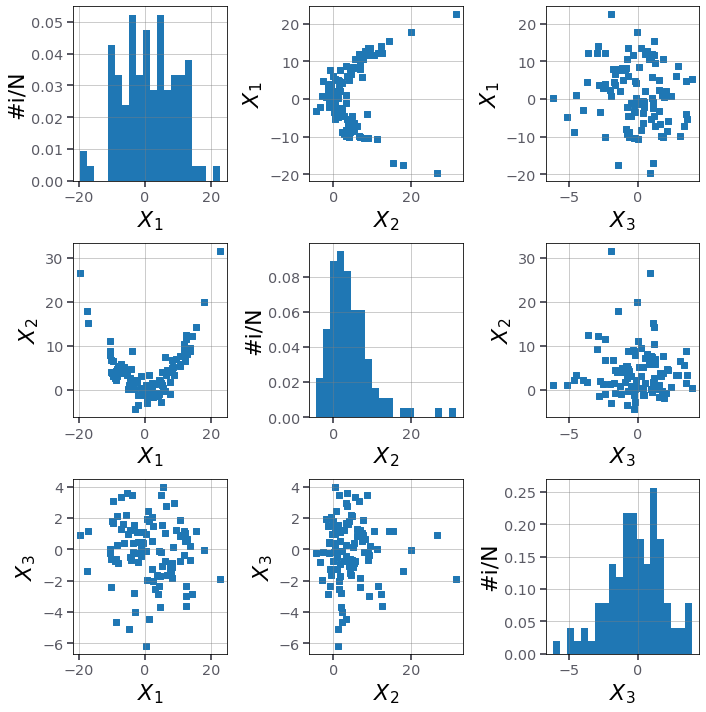

In [3]:
plot_scattermatrix(X,bins=20,figsize=(10,10))

## Run the inference algorithm

We can now apply the data-peeling procedure to output the *depth* of the data set.


In [4]:
a,b = data_peeling_algorithm(X,tol=0.01)
# a: is a list of subindices corresponding to the support vectors
# b: is a list of enclosing sets (boxes by default)

The depth of the data is an integer indicating how many levels there are.

We can now assign to each level a lower probability measure either using *scenario theory* or *c-boxes*. We'll set the confidence level to $\beta=0.01$.

In [5]:
f,p = peeling_to_structure(a,b,kind='scenario',beta=0.01)
# f: is a structure containing projections
# p: is a list of lower probability, one for each level

m:\git\CODE\clones\data-depth-inference\algorithm\scenario.py:77: RuntimeWarning: divide by zero encountered in log
  aux2 = numpy.sum(triu(log(repmat(m1-k,N-k+1,1)),k=1),axis=1) # aux2 = sum(triu(log(ones(N-k+1,1)*(m1-k)),1),2);
m:\git\CODE\clones\data-depth-inference\algorithm\scenario.py:102: RuntimeWarning: divide by zero encountered in log
  poly1 = 1+bet/(2*N)-bet/(2*N)*sum(exp(coeffs1 - (N-m1)*log(t1)))-bet/(6*N)*sum(exp(coeffs2 + (m2-N)*log(t1)));
m:\git\CODE\clones\data-depth-inference\algorithm\scenario.py:102: RuntimeWarning: invalid value encountered in multiply
  poly1 = 1+bet/(2*N)-bet/(2*N)*sum(exp(coeffs1 - (N-m1)*log(t1)))-bet/(6*N)*sum(exp(coeffs2 + (m2-N)*log(t1)));


With the enclosing sets and the lower measures associated to them, we can now plot the results

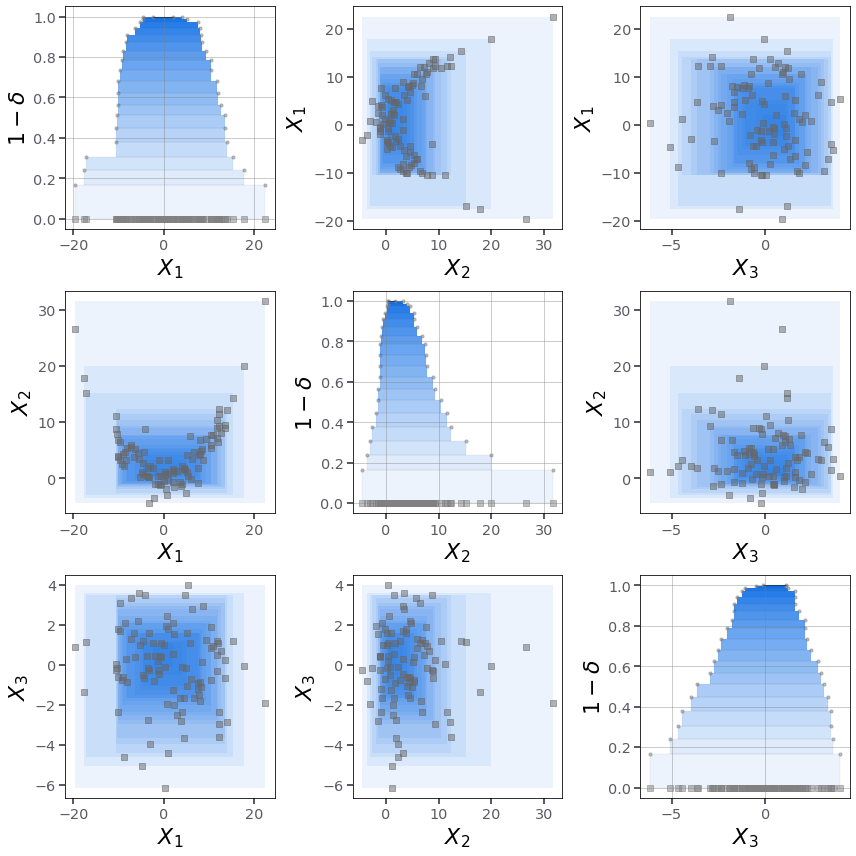

In [6]:
plot_peeling_nxd(X,a,b,p=p,figsize=(12,12))

The inference task terminates here. 

## What next?

(1) We can hypothesise a joint probability distribution $\hat{P}_{X}$ and check if it is contained in the consonant structure. 

Then, repeating this procedure we can build a set of compatible distribtions, however there will be no guarantee that these distributions are in the actual credal set. So by doing so we'll lose rigour. 

(2) We can use an possibility-to-imprecise-probability transform to turn these structures into p-boxes.

# Backward (indirect) inference problem

The backward inference problem targets $P_{Y}$, while characterising the inferential uncertainty of the quantity $X$, which is inderectly been observed via $Y=f(X)$.  

In other words, we target $P_{Y}$, while learning $P(X)$, with $Y=f(X)$.

We'll call $f$ a model, for example an engineering model.

## Generating synthetic data

Again we'll generate `n=100` iid samples from some data generating mechanism $P_{Y}$. Each sample $Y_i$ is a vector with two components: $Y_i \in R^2$, so $d=2$. 

However, this time we are going to need to know the model $f$ that links the input space $X$ with the output space $Y$. 

The model is as follows: $f:R^3 -> R^2$, so each sample in the input space is a vector with three components: $X_i \in R^3$, so $d\_=3$.

For simplicity and without loss of generality we'll assume that the model $f$ is the correct one. So $Y_i$ will be generated via the function itself.

Let us define the model as described above, so: $y = (3 x_1 * x_3,\ x_1^2 + x_2)$. 

In code the expression looks:


```python
import numpy
def f(x):
    d=2
    n,d_ = x.shape
    y = numpy.empty((n,d),dtype=float)
    y[:,0], y[:,1] = x[:,0]*3 + x[:,2], x[:,0]**2 + x[:,1] 
    return y
```

In [3]:
import numpy
def f(x):
    d=2
    n,d_ = x.shape
    y = numpy.empty((n,d),dtype=float)
    y[:,0], y[:,1] = x[:,0]*3 + x[:,2], x[:,0]**2 + x[:,1] 
    return y

Now we generate `n=100` random data for $X$ and pass it through $f$ to obtain our data $Y_i$.

In [4]:
import scipy.stats as stats
n, d_ = 100, 3
X_proxy = stats.norm(loc=0,scale=2).rvs((n,d_))
Y = f(X_proxy) # <- this is our target


## Run the inference algorithm

We can now run the backward inference procedure.

### Step 1: Bound the input space

Define bounds of the input space where it is expected the indirect observations to be placed. 

Clues may come from the physics of the problem under study. 


In [5]:
x_lo, x_hi = d_*[-10], d_*[10]

### Step 2: Cover the input space with evenly spaces samples

Ideally these samples are generated using a low-discrepancy sampling scheme. 

We'll use `100 000` samples for this example. 

In [6]:
ux = uniform(x_lo, x_hi, N=100_000)
ux.shape # prints (100000,3)

(100000, 3)

### Step 3: Evaluate the model on the coverage samples

This step is the most computationally expensive, and should be done offline and if possible and needed in parallel. 

Luckily this evaluation depends only on the bounds (previous step) and need not be repeated if the bounds don't change or the model doesn't change. 

In [7]:
uy = f(ux)
uy.shape # prints (100000,2)

(100000, 2)

### Step 4: Compute data depth of $Y$

In practice, we run the forward data-peeling algorithm for $Y$, subindexing the coverage samples in the output space. 


In [8]:
a,b,c = data_peeling_backward(uy,Y,tol=1e-1)
# a: a list of subindices corresponding to the support vectors
# b: a list of enclosing sets (boxes by default)
# c: a list of masks indicating the coverage samples belonging to each set

### Step 5: Compute lower probability measure and create structure

We'll use *scenario theory* to compute a lower probability measure for each enclosing set.

The data *depth* i.e. the number of levels is `l = len(a) = len(b) = len(c)`. 


In [9]:
fy,p = peeling_to_structure(a,b,kind='scenario',beta=0.01)
# fy: a structure containing projections (fuzzy structure)
# p: a list of lower probability, one for each level

fy.shape  # prints: (26,2,2)


m:\git\CODE\clones\data-depth-inference\algorithm\scenario.py:77: RuntimeWarning: divide by zero encountered in log
  aux2 = numpy.sum(triu(log(repmat(m1-k,N-k+1,1)),k=1),axis=1) # aux2 = sum(triu(log(ones(N-k+1,1)*(m1-k)),1),2);
m:\git\CODE\clones\data-depth-inference\algorithm\scenario.py:102: RuntimeWarning: divide by zero encountered in log
  poly1 = 1+bet/(2*N)-bet/(2*N)*sum(exp(coeffs1 - (N-m1)*log(t1)))-bet/(6*N)*sum(exp(coeffs2 + (m2-N)*log(t1)));
m:\git\CODE\clones\data-depth-inference\algorithm\scenario.py:102: RuntimeWarning: invalid value encountered in multiply
  poly1 = 1+bet/(2*N)-bet/(2*N)*sum(exp(coeffs1 - (N-m1)*log(t1)))-bet/(6*N)*sum(exp(coeffs2 + (m2-N)*log(t1)));


(27, 2, 2)

### Step 6: Obtain marginal structures (fuzzy numbers) by projecting the coverage samples

This steps builds the marginal fuzzy structures of the inderect observations. 


In [10]:
fx = samples_to_fuzzy_projection(ux,c)
# fy: a structure containing projections of the original multivariate structure in the input space

fx.shape # prints: (26,3,2)

(27, 3, 2)

### Plotting

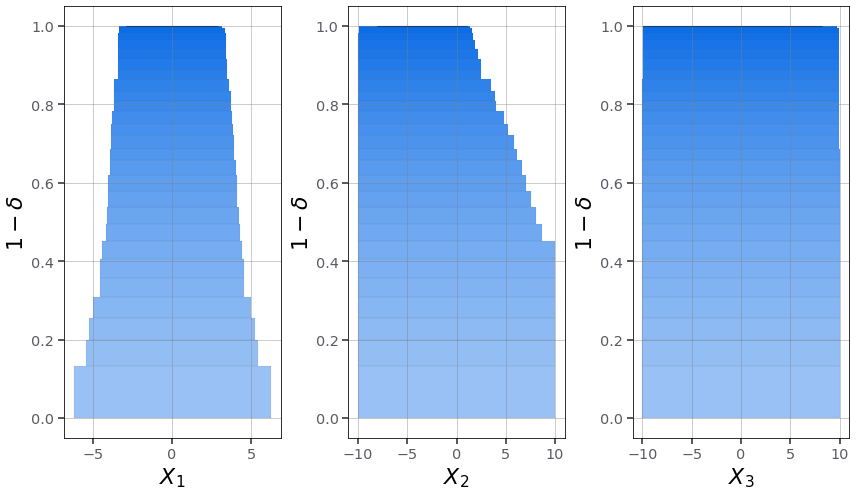

In [11]:
plot_fuzzy(fx,p=p,grid=True,figsize=(12,7))

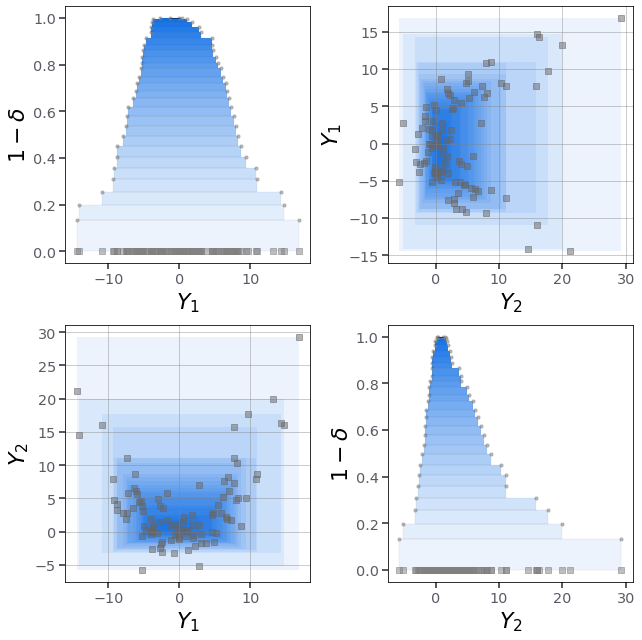

In [12]:
plot_peeling_nxd(Y,a,b,p=p,figsize=(9,9),grid=False,label='Y')

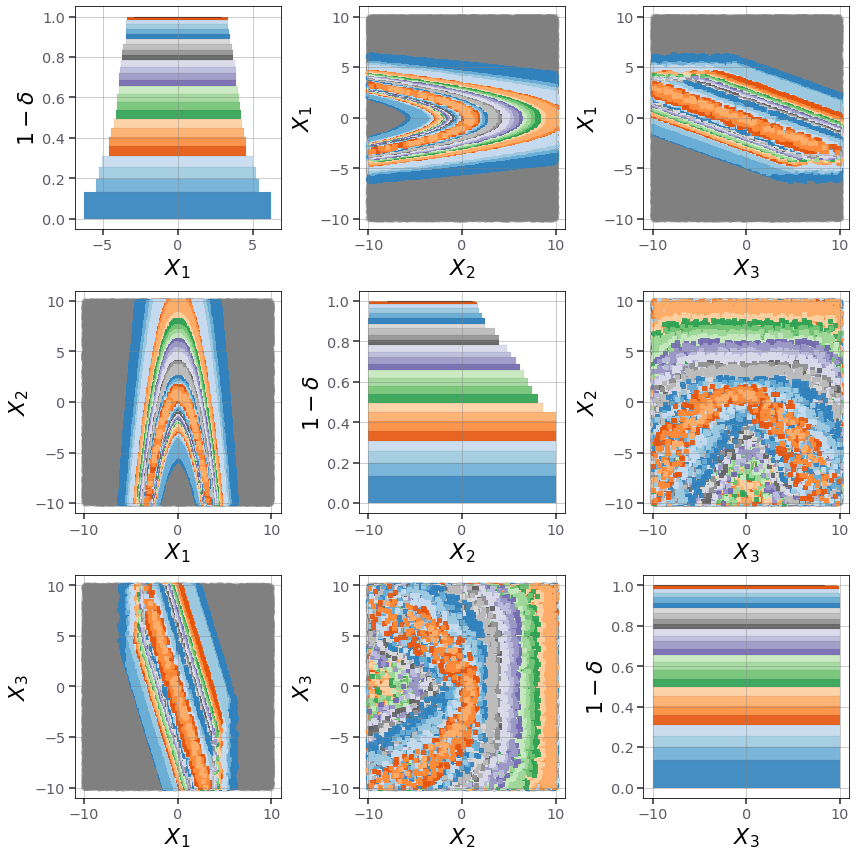

In [13]:
plot_peeling_nxd_back(ux,c,p=p,baseline_alpha=0.9,figsize=(12,12))